In [ ]:

import pandas as pd
import numpy as np
#علشان رسومات الجرافيك
import matplotlib.pyplot as plt
import seaborn as sns
#علشان نقسم الداتا ونختبرها ونتدربها
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#بنستخدمها علشان نقيم المودل من دقة وتقرير وكده
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score)
#علشان نوحد البيانات وتبقى ماشية سوا
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [ ]:
# Load the data
df = pd.read_csv('/content/Final-Merge-PCA.csv')
df_recent = df.sort_values('MONTHS_BALANCE').groupby('ID').first().reset_index()

In [ ]:
#بنحدد ايه الحاجات هنستخدمها علشان نتوقع منها نتيجه ال features
#وايه الحاجة اللي عايزين نتوقعها ال target
features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
            'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
            'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED']
target = 'STATUS'

X = df_recent[features]
y = df_recent[target]

In [ ]:
X_pca1=df.drop(columns=['ID', 'STATUS'])
y_pca= df['STATUS']
pca= PCA(n_components=10)
X_pca= pca.fit_transform(X_pca1)


In [ ]:
X_train_pca,X_test_pca,y_train_pca,y_test_pca=train_test_split(X_pca,y_pca,test_size=0.3,random_state=42)


In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_pca,y_train_pca)

In [ ]:
svm_best = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_best.fit(X_resampled, y_resampled)


SVC(probability=True, random_state=42)

In [ ]:
# Predictions and evaluation after hyperparameter tuning
y_pred_best = svm_best.predict(X_test_pca)
accuracy_best = accuracy_score(y_test_pca, y_pred_best)
precision_best = precision_score(y_test_pca, y_pred_best, average='macro')
recall_best = recall_score(y_test_pca, y_pred_best, average='macro')
f1_best = f1_score(y_test_pca, y_pred_best, average='macro')

print(f"Accuracy: {accuracy_best* 100:.2f}%")
print(f"Precision: {precision_best* 100:.2f}%")
print(f"Recall: {recall_best* 100:.2f}%")
print(f"F1 Score: {f1_best* 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test_pca, y_pred_best))

Accuracy: 64.58%
Precision: 50.88%
Recall: 51.87%
F1 Score: 48.09%

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      9258
           1       0.13      0.35      0.19      1221

    accuracy                           0.65     10479
   macro avg       0.51      0.52      0.48     10479
weighted avg       0.80      0.65      0.71     10479



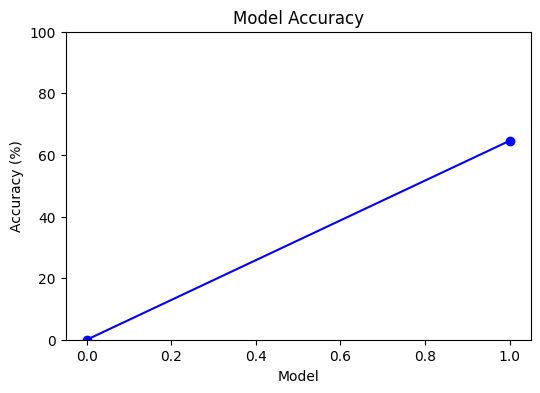

In [ ]:
#Accuracy Plo=رسم بياني هيوريني دقه الموديل

plt.figure(figsize=(6,4))
plt.plot([0, 1], [0, accuracy_best * 100], marker='o', color='b')
plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.show()


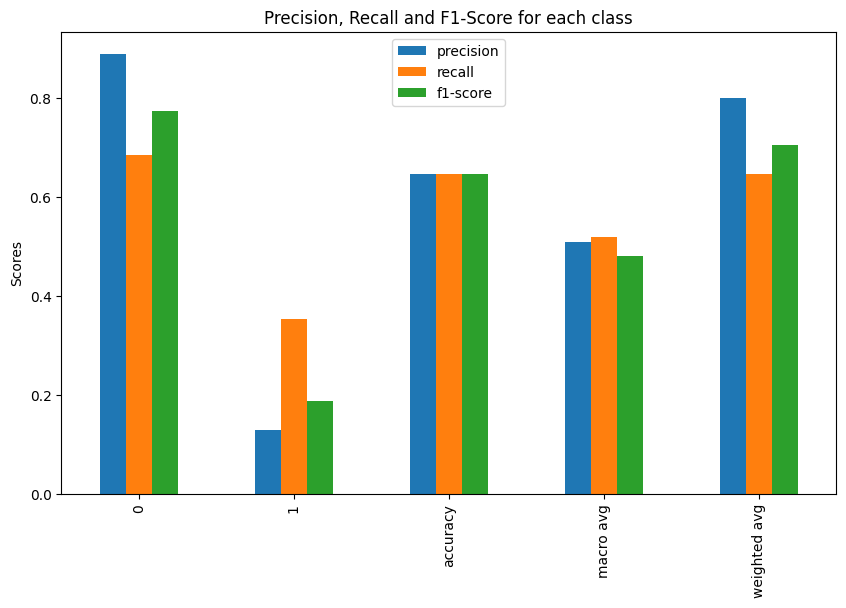

In [ ]:
#دقة الموديل (Accuracy)، الـ Recall، والـ F1-Score لكل فئة
report = classification_report(y_test_pca, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10,6))
plt.title('Precision, Recall and F1-Score for each class')
plt.ylabel('Scores')
plt.show()


Confusion Matrix:
[[6336 2922]
 [ 790  431]]


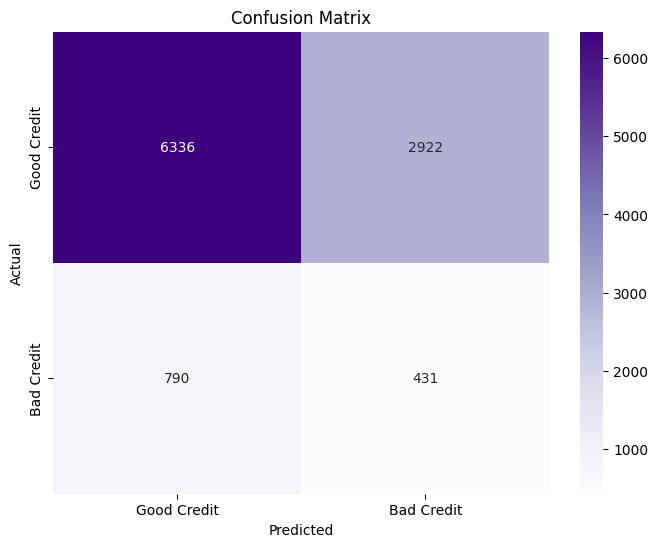

In [ ]:

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_pca,y_pred_best)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Good Credit', 'Bad Credit'],
            yticklabels=['Good Credit', 'Bad Credit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

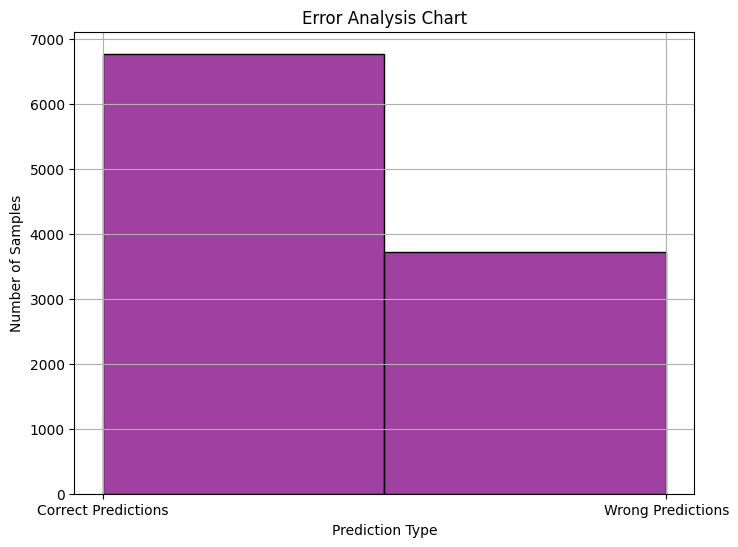

In [ ]:
# نعمل تحليل للأخطاء
errors = (y_pred_best != y_test_pca)

plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=2, kde=False, color='purple')
plt.xticks([0, 1], ['Correct Predictions', 'Wrong Predictions'])
plt.title('Error Analysis Chart')
plt.xlabel('Prediction Type')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()


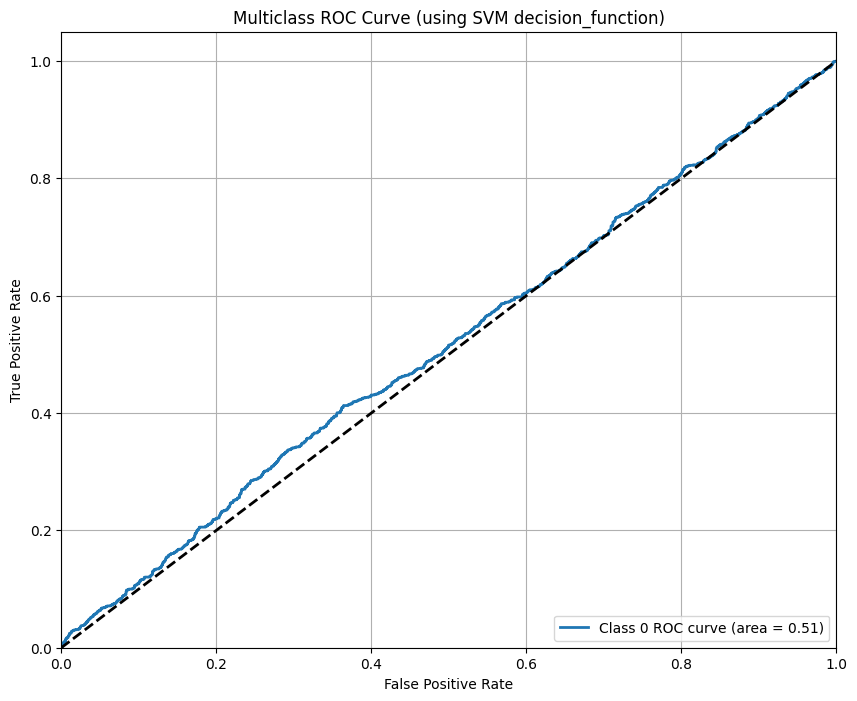

In [ ]:

# ROC Curve
classes = np.unique(y_test_pca)
y_test_bin = label_binarize(y_test_pca, classes=classes)
n_classes = y_test_bin.shape[1]

y_score = svm_best.decision_function(X_test_pca)
if n_classes == 1:
    y_score = y_score.reshape(-1, 1)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} ROC curve (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (using SVM decision_function)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


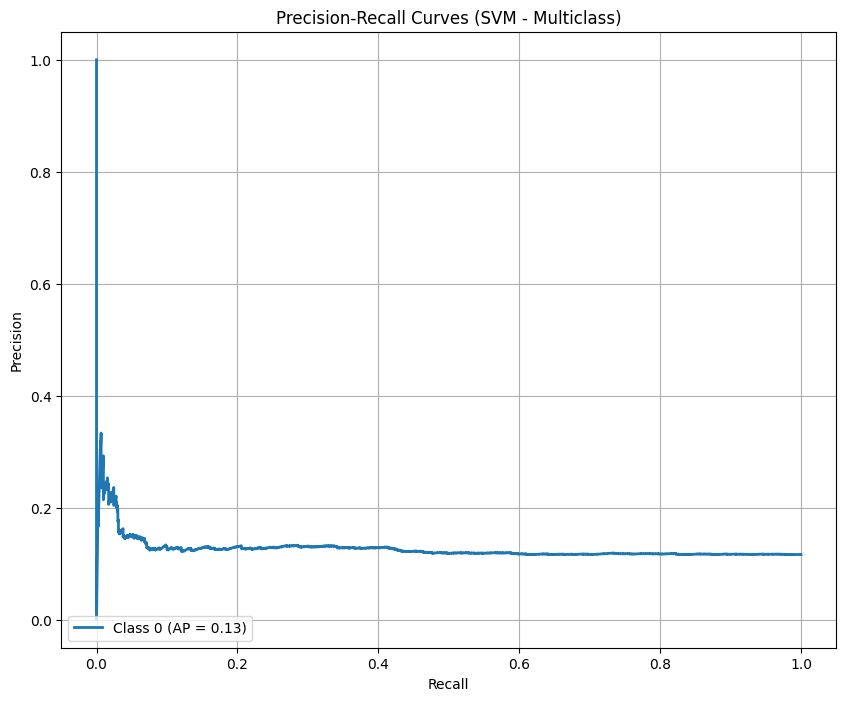

In [ ]:

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {classes[i]} (AP = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (SVM - Multiclass)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()